# This example shows how to train a simple model using PySaRe

In [10]:
import torch
import pysare
import numpy as np
import matplotlib.pyplot as plt

# Load Data
A dataset consists of:
- A matrix X of features, where the first dimension is the subject-dimension, i.e., each entry in the first dimension corresponds to subject.
 - A vector T with recorded times for each subject
 - A vector E with recorded times for each subject E[n] = True for a recorded event and False for a censoring

In [4]:

# t_m is the maximal time after which all subjects are censored failed
t_m = 3

# Simulate 1000 samples from a weibul distribution,
X, T, E = pysare.data.datasets.simulate_weibull_uniform_parameters(
    1000, output_dataset=False, t_m=t_m)

# Create a PySaRe dataset
dataset = pysare.data.Dataset(X, T, E)

# Slit into training and test set
training_set, validation_set = dataset.split(.9)

# Define data loaders
training_loader = torch.utils.data.DataLoader(training_set,
                                              shuffle=True,
                                              batch_size=1000)
validation_loader = torch.utils.data.DataLoader(validation_set,
                                                shuffle=False,
                                                batch_size=2000)


# Define the model

Below a Energy Based model with a multilayer perceptron (MLP) network with two layers of 100 nodes each, intervals is defined.

In [5]:
# Tail ratio used in the integration
tail_ratio = 1.2
# A monte carlo integration scheme with 20 samples is used for estimating gradients
train_integrator = pysare.models.energy_based.integrators.MonteCarlo(20)
# The trapezoidal rule on a uniform grid of 20 points is used for evaluation
eval_integrator = pysare.models.energy_based.integrators.UniformTrapezoidal(20)
# Define model
model = pysare.models.energy_based.EBM.MLP_implementation(
    t_m, tail_ratio, train_integrator, eval_integrator,
    num_features=2, layers=[100, 100])

A model can also be defined using the conventional pytorch style.

This is done by specifiying the forward method. It is important that the input and output dimensions are correct.


In [6]:
class my_EBM(pysare.models.energy_based.EBM):
    def __init__(self):
        # t_m and Integrators are passed to super class
        super(my_EBM, self).__init__(t_m=t_m, tail_ratio=tail_ratio,
                                     train_integrator=train_integrator, eval_integrator=eval_integrator)

        # Define network using conventional pytorch
        layerlist = []

        # first layer
        # The input size of the first layer is the number of features plus one
        # since time is also an input to the network
        input_size = 2+1
        layerlist.append(torch.nn.Linear(input_size, 100))
        layerlist.append(torch.nn.ReLU())

        # Last layer has a single output
        layerlist.append(torch.nn.Linear(100, 1))

        self.layers = torch.nn.Sequential(*layerlist)

    def forward(self, X):
        # The first column in X is the time
        logits = self.layers(X)

        return logits

# Train Model

Epoch 1
-------------------------------
Training loss: 0.794744  [    0/  900]
Test loss:     0.769520 
Epoch 2
-------------------------------
Training loss: 0.885757  [    0/  900]
Test loss:     0.721342 
Epoch 3
-------------------------------
Training loss: 0.750074  [    0/  900]
Test loss:     0.834956 
Epoch 4
-------------------------------
Training loss: 0.783311  [    0/  900]
Test loss:     0.800755 
Epoch 5
-------------------------------
Training loss: 0.751959  [    0/  900]
Test loss:     0.715778 
Epoch 6
-------------------------------
Training loss: 0.705014  [    0/  900]
Test loss:     0.672296 
Epoch 7
-------------------------------
Training loss: 0.700805  [    0/  900]
Test loss:     0.657627 
Epoch 8
-------------------------------
Training loss: 0.697049  [    0/  900]
Test loss:     0.647609 
Epoch 9
-------------------------------
Training loss: 0.670932  [    0/  900]
Test loss:     0.658677 
Epoch 10
-------------------------------
Training loss: 0.643946

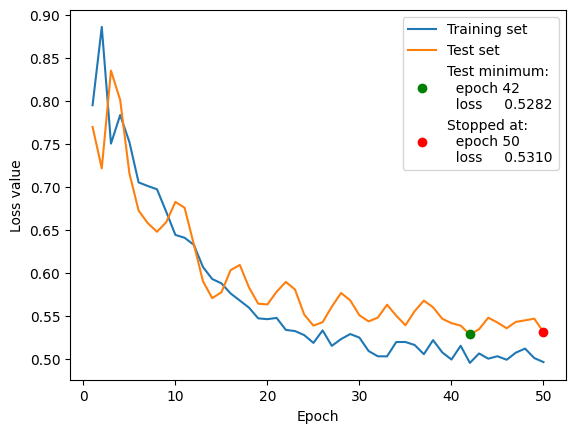

In [16]:
# Construct model
model = my_EBM()

# A torch optimizer is chosen to train the model
optimizer = torch.optim.Adam(model.parameters(), lr=5e-2, weight_decay=0.00)

# Path to where the best model is stored during training, when basic_training
# finish it will automatically load the best model. Set to None to disable
best_model_checkpoint_path = "intro_best_model"

# Basic training trains the netork using negative log-likelihood as loss function
training_log = pysare.training.basic_training(
    model,
    training_loader,
    optimizer,
    num_epochs=50,
    validation_loader=validation_loader,
    best_model_checkpoint_path=best_model_checkpoint_path)

# Plot the training
training_log.plot()


Alternatively, a loop can be defined by the user or using tools like pytorch-lightning
Here an example of a user-defined training loop is shown

In [18]:
device = 'cpu'
model = my_EBM()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-2, weight_decay=0.00)

for epoch in range(50):
    epoch_loss = 0.0
    for batch, (X, T, E) in enumerate(training_loader):

        # Compute negative log-likelihood
        loss = -model._log_likelihood(X, T, E).sum()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= training_loader.dataset.X.shape[0]
    print(f"Epoch {epoch + 1}")
    print(f"Training loss: {epoch_loss:>7f} \n-------------------------------")

Epoch 1
Training loss: 0.786459 
-------------------------------
Epoch 2
Training loss: 0.869816 
-------------------------------
Epoch 3
Training loss: 0.765380 
-------------------------------
Epoch 4
Training loss: 0.810325 
-------------------------------
Epoch 5
Training loss: 0.748172 
-------------------------------
Epoch 6
Training loss: 0.727107 
-------------------------------
Epoch 7
Training loss: 0.738154 
-------------------------------
Epoch 8
Training loss: 0.709793 
-------------------------------
Epoch 9
Training loss: 0.678018 
-------------------------------
Epoch 10
Training loss: 0.680668 
-------------------------------
Epoch 11
Training loss: 0.664821 
-------------------------------
Epoch 12
Training loss: 0.635531 
-------------------------------
Epoch 13
Training loss: 0.631081 
-------------------------------
Epoch 14
Training loss: 0.624620 
-------------------------------
Epoch 15
Training loss: 0.602648 
-------------------------------
Epoch 16
Training l

# Plot Model
Here it is shown how the trained model can be used by plotting its survival function and lifetime density.

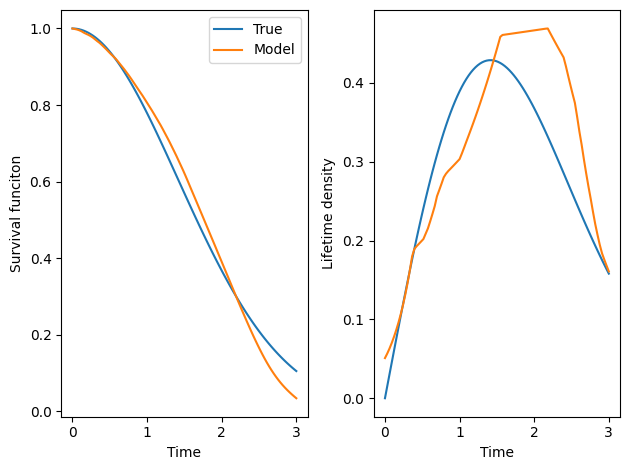

In [19]:
# Define a vector with times to evaluate the model on
t = np.linspace(0, 3, 100)

# We plot the model for  shape parameter
k = 2
# and scale parameters
l = 2

# X should have the shape (N, M1,...) where N is the number of subjects
# and (Mi,...) is the shape of a singel feature vector.
# Our feature vector is
x = [k, l]
# and therfore
X = [x]
# i.e., doulbe brackets are used to indicate that it is a single subject.

# Calculate the modeleed survival function and lifetime density
S = model.survival_probability(X, t)
f = model.lifetime_density(X, t)

# Plot
fig, ax = plt.subplots(1, 2, num=1, clear=True)
ax[0].plot(t, np.exp(-(t/l)**k), label='True')  # True survival function
ax[0].plot(t, S, label='Model')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Survival funciton')
ax[0].legend()
ax[1].plot(t, (k/l)*(t/l)**(k-1)*np.exp(-(t/l)**k))  # True lifetime density
ax[1].plot(t, f)
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Lifetime density')
plt.tight_layout()

# Evaluate Model
Evaluation of the model using common evaluation metrics

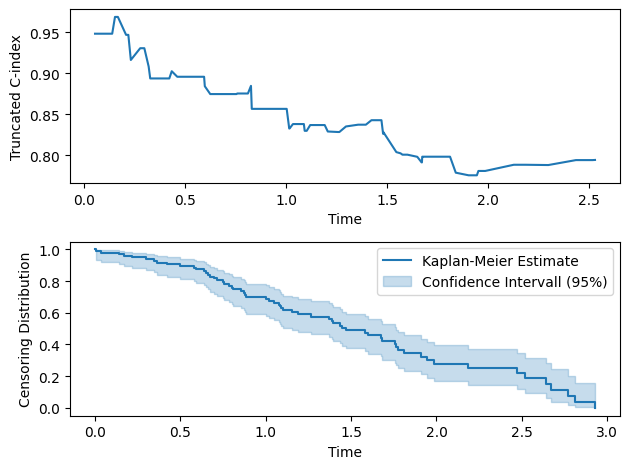

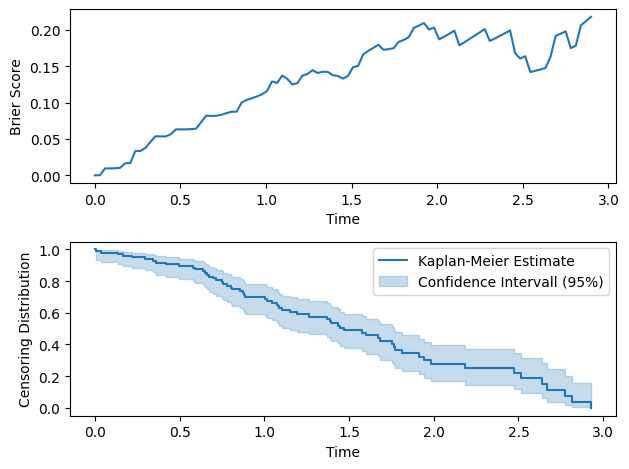

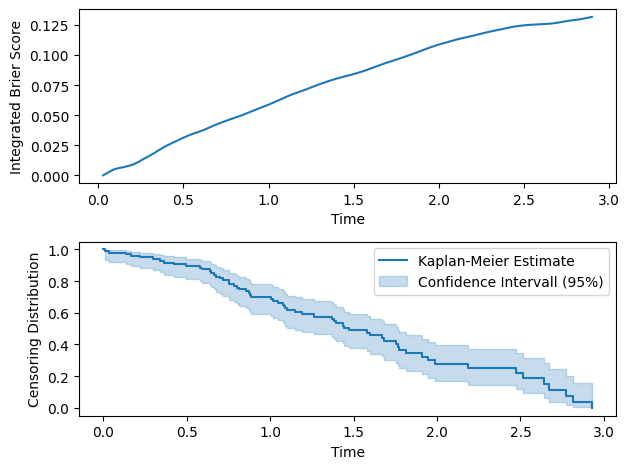

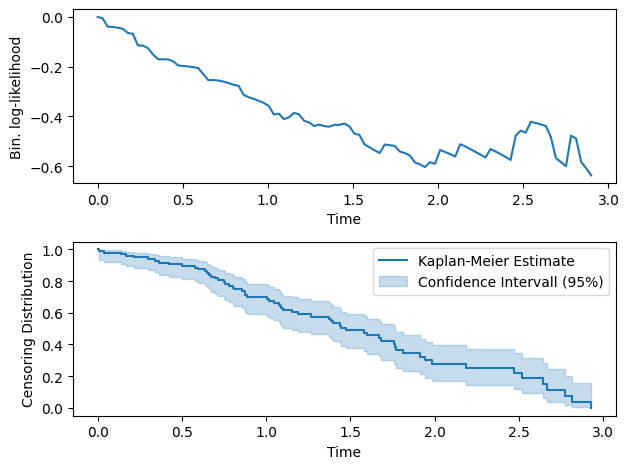

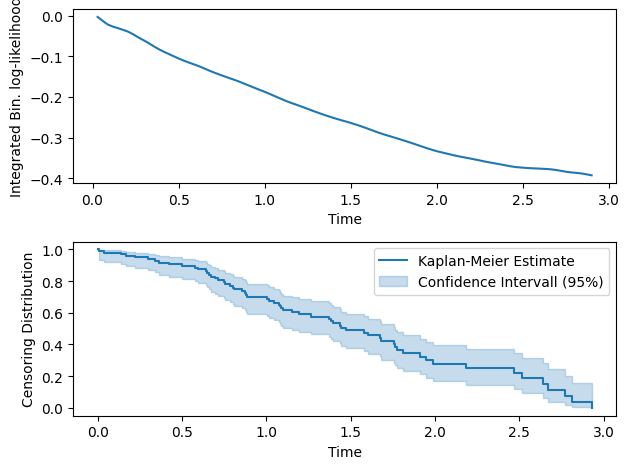

In [20]:
C_index = pysare.evaluation.concordance_index(model, validation_set)
BS = pysare.evaluation.brier_score(model, validation_set, num_t=100)
IBS = pysare.evaluation.integrated_brier_score(
    model, validation_set, num_t=100)
BLL = pysare.evaluation.binomial_log_likelihood(
    model, validation_set, num_t=100)
IBLL = pysare.evaluation.integrated_binomial_log_likelihood(
    model, validation_set, num_t=100)

Plot all in same figure

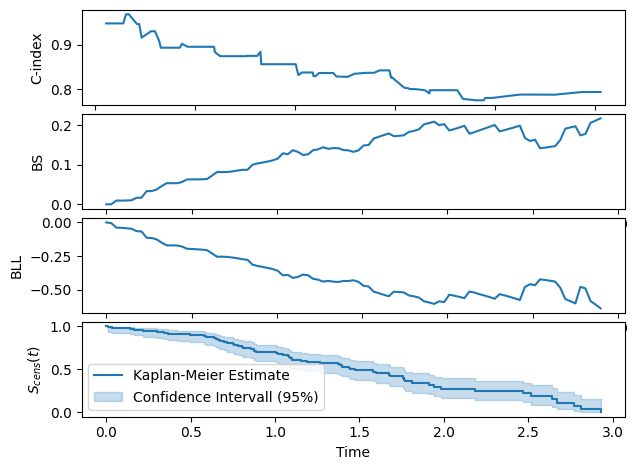

In [21]:
fig, ax = plt.subplots(4, 1, num=1, clear=True)
C_index = pysare.evaluation.concordance_index(
    model, validation_set, ax=ax[[0, 3]])
ax[0].set(xlabel=None)
ax[0].set(ylabel='C-index')
BS = pysare.evaluation.brier_score(
    model, validation_set, num_t=100, ax=ax[[1, 3]])
# IBS = pysare.evaluation.integrated_brier_score(model, validation_set, num_t=100, ax=ax[[1,4]])
ax[3].clear()
BLL = pysare.evaluation.binomial_log_likelihood(
    model, validation_set, num_t=100, ax=ax[[2, 3]])
# IBLL = pysare.evaluation.integrated_binomial_log_likelihood(model, validation_set, num_t=100, ax=ax[[2,4]])
ax[0].set(ylabel='C-index')
ax[1].set(ylabel='BS')
ax[2].set(ylabel='BLL')
ax[3].set(ylabel='$S_{cens}(t)$')
plt.subplots_adjust(hspace=.1, wspace=0)